# Sign Language Detection with LSTM and Mediapipe
[Mediapipe](https://mediapipe.dev/).

This tutorial was created and mostly copied from [Nicholas Renotte Sign Language Detection using ACTION RECOGNITION with Python | LSTM Deep Learning Model](https://youtu.be/doDUihpj6ro). [Original Project Github Link](https://github.com/nicknochnack/ActionDetectionforSignLanguage)

# Contents

1. [Import Dependencies](#1)
1. [Keypoints using MP Holistic](#2)
    1. [Holistic Detection with FPS Counter](#14)
1. [Extract Keypoint Values](#3)
    1. [Extract from the Pose Results](#4)
        1. [Make a List for Pose of Frame](#5)
        1. [Make an Numpy Array for Pose of Frame](#6)
        1. [Determine for Input for LSTM Network](#7)
    1. [Extract Keypoints Values from Face and Hands Results](#8)
    1. [Error Handling for No Results Situations](#9)
    1. [The Final Input Arrays and Function](#10)
1. [Setup Folders for Collection](#11)
1. [Collect Keypoint Values for Training and Testing](#12)
1. [Preprocess Data and Create Labels and Features](#13)
    1. [Split Train and Test Data](#17)
1. [Build and Train LSTM Neural Network](#15)
1. [Make Precitions](#16)
1. [Save Model](#18)
1. [Evaluation using Confusion Matrix and Accuracy](#19)
    1. [Evaluating on Training Set](#21)
    1. [Evaluating on Test Set](#22)

1. [Test in Real Time](#20)
    1. [Expected Input for LSTM Model](#23)
    1. [Visualization: How to Works](#25)
    1. [Real Time Detection with Webcam](#24)
    

1. [Appendix](#99)
    1. [Results of Pose Landmarks](#100)
    1. [Results of Pose Landmarks](#100)
    1. [os.makedirs file already exists error](#102)
    


<a id="1"></a>
# Import Dependencies

In [37]:
import tensorflow as tf
import cv2 
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import keras as k

In [38]:
print("tf:", tf.__version__)
print("Keras", k.__version__)
print("cv2:", cv2.__version__)
print("np:", np.__version__)

tf: 2.5.0
Keras 2.5.0
cv2: 4.5.5
np: 1.19.5


<a id="2"></a>
# 2. Keypoints using MP Holistic

In [39]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [40]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [41]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [42]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [14]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('Results', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
cap.release()
cv2.destroyAllWindows()

<a id="14"></a>
## 2.A. Holistic Detection with FPS Counter

In [21]:
cap = cv2.VideoCapture(0)

# used to record the time when we processed last frame
prev_frame_time = 0
# used to record the time at which we processed current frame
new_frame_time = 0

# Initiate holistic model
with mp_holistic.Holistic(model_complexity=1, min_detection_confidence=0.5, 
                          min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        
        # time when we finish processing for this frame
        new_frame_time = time.time()
        
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # fps will be number of frame processed in given time frame
        # since their will be most of time error of 0.001 second
        # we will be subtracting it to get more accurate result
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time

        # converting the fps into integer
        fps = int(fps)
        
        # converting the fps to string so that we can display it on frame
        # by using putText function
        fps = str(fps)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # putting the FPS count on the frame
        cv2.putText(image, fps, (7, 70), font, 1, (100, 255, 0), 3, cv2.LINE_AA)
    
        cv2.imshow('Webcam with Detections', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

<center>
<div class="alert alert-block alert-warning">
<b>Info:</b> Getting 15-20 fps right now.
</div>
</center>

<a id="3"></a>
# 3. Extract Keypoint Values

[Results of Pose Landmarks are shown in the appendix.](#100)

In [22]:
results

mediapipe.python.solution_base.SolutionOutputs

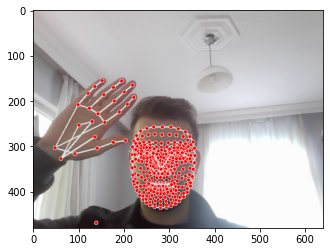

In [23]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

<a id="4"></a>
## 3.A. Extract Keypoints Values from the Pose Results
[Results of Pose Landmarks are shown in the appendix.](#100)

In [24]:
len(results.pose_landmarks.landmark)

33

In [12]:
#Example
results.pose_landmarks.landmark[0]

x: 0.5141614079475403
y: 0.6165520548820496
z: -1.25775945186615
visibility: 0.999890923500061

In [13]:
results.pose_landmarks.landmark[0].x

0.5141614079475403

<a id="5"></a>
### 3.A.a. Make a List for Pose of Frame

In [14]:
for i, res in enumerate(results.pose_landmarks.landmark):
    test = np.array([res.x, res.y, res.z, res.visibility])
    print(i,": ", test)

0 :  [ 0.51416141  0.61655205 -1.25775945  0.99989092]
1 :  [ 0.55111563  0.54507172 -1.17968035  0.99981564]
2 :  [ 0.56976366  0.54401785 -1.17947507  0.99971282]
3 :  [ 0.58554864  0.54434967 -1.17963982  0.99970639]
4 :  [ 0.48639673  0.54793304 -1.16285384  0.99985468]
5 :  [ 0.46225613  0.54766738 -1.16211605  0.99984491]
6 :  [ 0.44253802  0.54701072 -1.16233289  0.99989635]
7 :  [ 0.61597383  0.57685852 -0.67488194  0.99964345]
8 :  [ 0.42484012  0.57580578 -0.57358116  0.99991494]
9 :  [ 0.55367172  0.68515056 -1.07539344  0.99987185]
10 :  [ 0.47169375  0.68425041 -1.0490272   0.999937  ]
11 :  [ 0.75430995  0.93799049 -0.38094968  0.99431765]
12 :  [ 0.27315301  0.89302522 -0.35905725  0.99938464]
13 :  [ 0.89079112  1.4007318  -0.36563292  0.18669201]
14 :  [-0.06555679  1.024261   -1.08029437  0.9212842 ]
15 :  [ 0.90250504  1.7410413  -0.52428687  0.10095713]
16 :  [ 0.13169168  0.63971478 -2.03506994  0.87573814]
17 :  [ 0.93885076  1.85246527 -0.60532808  0.1005643 ]
18

In [15]:
pose = [] # a list for pose results
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)
pose

[array([ 0.51416141,  0.61655205, -1.25775945,  0.99989092]),
 array([ 0.55111563,  0.54507172, -1.17968035,  0.99981564]),
 array([ 0.56976366,  0.54401785, -1.17947507,  0.99971282]),
 array([ 0.58554864,  0.54434967, -1.17963982,  0.99970639]),
 array([ 0.48639673,  0.54793304, -1.16285384,  0.99985468]),
 array([ 0.46225613,  0.54766738, -1.16211605,  0.99984491]),
 array([ 0.44253802,  0.54701072, -1.16233289,  0.99989635]),
 array([ 0.61597383,  0.57685852, -0.67488194,  0.99964345]),
 array([ 0.42484012,  0.57580578, -0.57358116,  0.99991494]),
 array([ 0.55367172,  0.68515056, -1.07539344,  0.99987185]),
 array([ 0.47169375,  0.68425041, -1.0490272 ,  0.999937  ]),
 array([ 0.75430995,  0.93799049, -0.38094968,  0.99431765]),
 array([ 0.27315301,  0.89302522, -0.35905725,  0.99938464]),
 array([ 0.89079112,  1.4007318 , -0.36563292,  0.18669201]),
 array([-0.06555679,  1.024261  , -1.08029437,  0.9212842 ]),
 array([ 0.90250504,  1.7410413 , -0.52428687,  0.10095713]),
 array([

In [16]:
len(pose)

33

In [17]:
type(pose)

list

<a id="6"></a>
### 3.A.b. Make an Numpy Array for Pose of Frame

In [18]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark])
pose

array([[ 5.14161408e-01,  6.16552055e-01, -1.25775945e+00,
         9.99890924e-01],
       [ 5.51115632e-01,  5.45071721e-01, -1.17968035e+00,
         9.99815643e-01],
       [ 5.69763660e-01,  5.44017851e-01, -1.17947507e+00,
         9.99712825e-01],
       [ 5.85548639e-01,  5.44349670e-01, -1.17963982e+00,
         9.99706388e-01],
       [ 4.86396730e-01,  5.47933042e-01, -1.16285384e+00,
         9.99854684e-01],
       [ 4.62256134e-01,  5.47667384e-01, -1.16211605e+00,
         9.99844909e-01],
       [ 4.42538023e-01,  5.47010720e-01, -1.16233289e+00,
         9.99896348e-01],
       [ 6.15973830e-01,  5.76858521e-01, -6.74881935e-01,
         9.99643445e-01],
       [ 4.24840122e-01,  5.75805783e-01, -5.73581159e-01,
         9.99914944e-01],
       [ 5.53671718e-01,  6.85150564e-01, -1.07539344e+00,
         9.99871850e-01],
       [ 4.71693754e-01,  6.84250414e-01, -1.04902720e+00,
         9.99936998e-01],
       [ 7.54309952e-01,  9.37990487e-01, -3.80949676e-01,
      

In [19]:
print("Length of Pose:",len(pose))
print("Shape of Pose:", pose.shape)

Length of Pose: 33
Shape of Pose: (33, 4)


In [20]:
type(pose)

numpy.ndarray

<a id="7"></a>
### 3.A.c. Determine for Input for LSTM Network

In [21]:
# this is input format for LSTM 
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()

In [22]:
print("Shape of Pose:", pose.shape)
print("Pose: \n",pose)

Shape of Pose: (132,)
Pose: 
 [ 5.14161408e-01  6.16552055e-01 -1.25775945e+00  9.99890924e-01
  5.51115632e-01  5.45071721e-01 -1.17968035e+00  9.99815643e-01
  5.69763660e-01  5.44017851e-01 -1.17947507e+00  9.99712825e-01
  5.85548639e-01  5.44349670e-01 -1.17963982e+00  9.99706388e-01
  4.86396730e-01  5.47933042e-01 -1.16285384e+00  9.99854684e-01
  4.62256134e-01  5.47667384e-01 -1.16211605e+00  9.99844909e-01
  4.42538023e-01  5.47010720e-01 -1.16233289e+00  9.99896348e-01
  6.15973830e-01  5.76858521e-01 -6.74881935e-01  9.99643445e-01
  4.24840122e-01  5.75805783e-01 -5.73581159e-01  9.99914944e-01
  5.53671718e-01  6.85150564e-01 -1.07539344e+00  9.99871850e-01
  4.71693754e-01  6.84250414e-01 -1.04902720e+00  9.99936998e-01
  7.54309952e-01  9.37990487e-01 -3.80949676e-01  9.94317651e-01
  2.73153007e-01  8.93025219e-01 -3.59057248e-01  9.99384642e-01
  8.90791118e-01  1.40073180e+00 -3.65632921e-01  1.86692014e-01
 -6.55567870e-02  1.02426100e+00 -1.08029437e+00  9.21284199

<a id="8"></a>
## 3.B. Extract Keypoints Values from Face and Hands Results

<div class="alert alert-block alert-warning">
<b>Note:</b> There are no visibility values for face and hands
</div>

In [23]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])
print(face.shape)

(468, 3)


In [29]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()

In [30]:
print("Shape of face results: ", face.shape)
print(face)

Shape of face results:  (1404,)
[ 0.5259276   0.68227011 -0.01917047 ...  0.59534889  0.53105265
  0.00102406]


In [31]:
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark])
rh.shape

(21, 3)

In [32]:
# right hand
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()

In [33]:
rh.shape

(63,)

In [34]:
# left hand
lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten()

AttributeError: 'NoneType' object has no attribute 'landmark'

<div class="alert alert-block alert-warning">
<b>Note:</b> There is no left hand on the image, so there are no results of the left hand.
</div>

<a id="9"></a>
## 3.C. Error Handling for No Results Situations

<div class="alert alert-block alert-info">
<b>Info:</b> If there is not some part of the results on the image like the left hand, we need to handle the error when we want to convert results to inputs. In order to fix it, we will create a NumPy array with zeros as it should be shape of the input. 
</div>

In [35]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark])
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark])
# same as right hand
# lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark])

In [36]:
print("Shape of pose results: ", pose.shape)
print("Shape of face results: ", face.shape)
print("Shape of right hand results: ", rh.shape)

Shape of pose results:  (33, 4)
Shape of face results:  (468, 3)
Shape of right hand results:  (21, 3)


In [37]:
print("Shape of pose results: ", pose.flatten().shape)
print("Shape of face results: ", face.flatten().shape)
print("Shape of right hand results: ", rh.flatten().shape)

Shape of pose results:  (132,)
Shape of face results:  (1404,)
Shape of right hand results:  (63,)


In [38]:
# for hands results
np.zeros(21*3).shape

(63,)

<a id="10"></a>
## 3.D. The Final Input Arrays and Function

In [39]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)

In [40]:
print("Shape of pose results: ", pose.shape)
print("Shape of face results: ", face.shape)
print("Shape of right hand results: ", rh.shape)
print("Shape of left hand results: ", lh.shape)

Shape of pose results:  (132,)
Shape of face results:  (1404,)
Shape of right hand results:  (63,)
Shape of left hand results:  (63,)


In [43]:
# The final extract keypoints function
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    return np.concatenate([pose, face, lh, rh])

In [42]:
extract_keypoints(results).shape

(1662,)

<a id="11"></a>
# 4. Setup Folders for Collection

We use Turkish Sign Language for 3 words.

In [44]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('workspace/data') 

# Actions that we try to detect
actions = np.array(['merhaba', 'gunaydin', 'seniseviyorum'])

# Thirty videos worth of data. no_sequences : number of sequences
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

- "Merhaba" means hello in Turkish. Here is the [link](https://youtu.be/15xh4aNPKAM?list=PLflEAUnN_mr9CJQSe6zxx3iT8by5exh5G&t=203) that shows you how to do that.
- "Gunaydın" means in Turkish good morning. Here is the [link](https://youtu.be/n6LulS3PFkk?list=PLflEAUnN_mr9CJQSe6zxx3iT8by5exh5G&t=207)
- "Seni Seviyorum" means I love you. Here is the [link](https://youtu.be/eS2l_yqxLBw)

In [44]:
# merhaba
## 0
## 1
## 2
## ...
## 29
# gunaydin
## 0
## 1
## 2
## ...
# seniseviyorum
#...

In [17]:
# create data class folders
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            # If folder exist, raises error
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

If we want to add new folders for new data, we can add it safely. Because the code above tries to make a new folder but if it exists, it passes.
To see [os.makedirs file already exists error](#102)

<a id="12"></a>
# 5. Collect Keypoint Values for Training and Testing

In [45]:
def progress_bar(image, percentage:int=5, size_x=100, size_y:int=10, height_from_bottom=5):
    """Progress bar for image
    
    Args:
        image: image that want you put progress bar on it
        percentage: an integer value percentage of fullness of bar
        size_y: an integer value for height of your bar
        size_x: an integer value for width of your bar
        height_from_bottom : progress bar height from the bottom of the image
    
    Returns:
        Image: the image that the progress bar added
    
    """
    
    height, width, _ = image.shape
    hfb = height - height*height_from_bottom/100

    
    # Thickness of -1 will fill the entire shape
    thickness = -1
    
    percentage = percentage * size_x / 100
    
    # FULL PART
    # represents the top left corner of rectangle 1
    r1_x1 = int(width/2 - size_x/2)
    r1_y1 = int(hfb - size_y)
    start_point_1 = (r1_x1, r1_y1)
    
    # represents the bottom right corner of rectangle 1
    r1_x2 = int(r1_x1 + percentage)
    r1_y2 = int(hfb)
    end_point_1 = (r1_x2, r1_y2)
    
    
    # Color in BGR
    color1 = (85, 240, 24) 
    
    #rectangle 1 full
    image = cv2.rectangle(image, start_point_1, end_point_1, color1, thickness)
    
    
    # EMPTY PART
    if not percentage == 100:
        r2_x1 = r1_x2
        r2_y1 = r1_y1
        start_point_2 = (r2_x1, r2_y1)

        # represents the bottom right corner of rectangle 1
        r2_x2 = int(r2_x1 +(size_x-percentage))
        r2_y2 = int(hfb)
        end_point_2 = (r2_x2, r2_y2)

        color2 = (245, 135, 66)

        #rectangle 2 empty
        image = cv2.rectangle(image, start_point_2, end_point_2, color2, thickness)
        
    return image

In [18]:
cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        
        ret, frame = cap.read()
        cv2.putText(frame, 'New Action({}) will be collected frames.'.format(action), (10,200), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255, 0), 2, cv2.LINE_AA)                
        cv2.imshow('OpenCV Feed', frame)
        cv2.waitKey(30000) 
        
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    for i in range(1,101,1):
                        
                        # Read feed
                        ret, frame = cap.read()
                        # Make detections
                        image, results = mediapipe_detection(frame, holistic)
                        # Draw landmarks
                        draw_styled_landmarks(image, results)
                
                        cv2.putText(image, f'STARTING COLLECTION {int((100-i)/10)+1}', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        
                        image2 = image.copy()
                        image2 = progress_bar(image2, percentage=i)
                        
                        
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image2)
                        cv2.waitKey(1)
                        
                else: 
                    image = progress_bar(image, percentage=frame_num*100/sequence_length)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
cap.release()
cv2.destroyAllWindows()

In [16]:
cap.release()
cv2.destroyAllWindows()

<a id="13"></a>
# 6. Preprocess Data and Create Labels and Features

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [47]:
label_map = {label:num for num, label in enumerate(actions)}

In [48]:
label_map

{'merhaba': 0, 'gunaydin': 1, 'seniseviyorum': 2}

In [49]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [50]:
np.array(sequences).shape

(90, 30, 1662)

In [51]:
np.array(labels).shape

(90,)

In [52]:
X = np.array(sequences)

In [53]:
X.shape

(90, 30, 1662)

In [54]:
y = to_categorical(labels).astype(int)

In [55]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

<a id="17"></a>
## 6.A. Split Train and Test Data

In [56]:
X_train, X_test  , y_train, y_test = train_test_split(X, y, test_size=0.05)

In [57]:
X_train.shape

(85, 30, 1662)

In [58]:
X_test.shape

(5, 30, 1662)

In [59]:
y_test.shape

(5, 3)

<a id="15"></a>
# 7. Build and Train LSTM Neural Network

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [71]:
# example of logs name
time_of_model = time.strftime('%Y_%m_%d_time_%H_%M_%S',time.localtime())
name_of_training_logs = f"Log_{time_of_model}"
name_of_training_logs

'Log_2022_04_30_time_17_58_53'

In [72]:
time_of_model = time.strftime('%Y_%m_%d_time_%H_%M_%S',time.localtime())
name_of_training_logs = f"Log_{time_of_model}"

log_dir = os.path.join(f"Logs/{name_of_training_logs}")
tb_callback = TensorBoard(log_dir=log_dir)

In [61]:
def create_model():
    
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions.shape[0], activation='softmax'))
    
    return model

model = create_model()

In [62]:
actions.shape[0]  # number of our classes

3

In [75]:
# Assume res is our model output. (Probabilities of classes.)
res = [.7, 0.2, 0.1]

print("np.argmax :",np.argmax(res))  # Returns the indices of the maximum values along an axis.

print("Detected Action:", actions[np.argmax(res)])

np.argmax : 0
Detected Action: merhaba


In [76]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [77]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 64)            442112    
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

In [78]:
epochs=200
model.fit(X_train, y_train, epochs=epochs, callbacks=[tb_callback])

Epoch 1/200
3/3 [==============================] - 4s 605ms/step - loss: 1.4403 - categorical_accuracy: 0.3294
Epoch 2/200
3/3 [==============================] - 1s 372ms/step - loss: 1.4976 - categorical_accuracy: 0.2706
Epoch 3/200
3/3 [==============================] - 1s 393ms/step - loss: 1.0952 - categorical_accuracy: 0.3412
Epoch 4/200
3/3 [==============================] - 1s 358ms/step - loss: 1.3214 - categorical_accuracy: 0.3529
Epoch 5/200
3/3 [==============================] - 1s 361ms/step - loss: 1.0641 - categorical_accuracy: 0.4118
Epoch 6/200
3/3 [==============================] - 1s 362ms/step - loss: 1.0538 - categorical_accuracy: 0.3294
Epoch 7/200
3/3 [==============================] - 1s 339ms/step - loss: 0.9885 - categorical_accuracy: 0.4353
Epoch 8/200
3/3 [==============================] - 1s 370ms/step - loss: 1.0895 - categorical_accuracy: 0.3176
Epoch 9/200
3/3 [==============================] - 1s 322ms/step - loss: 1.1141 - categorical_accuracy: 0.3176
E

3/3 [==============================] - 1s 321ms/step - loss: 0.4091 - categorical_accuracy: 0.9059
Epoch 147/200
3/3 [==============================] - 1s 415ms/step - loss: 0.3714 - categorical_accuracy: 0.9412
Epoch 148/200
3/3 [==============================] - 1s 388ms/step - loss: 0.3385 - categorical_accuracy: 0.9647
Epoch 149/200
3/3 [==============================] - 1s 350ms/step - loss: 0.3443 - categorical_accuracy: 0.9176
Epoch 150/200
3/3 [==============================] - 1s 378ms/step - loss: 0.2842 - categorical_accuracy: 0.9529
Epoch 151/200
3/3 [==============================] - 1s 317ms/step - loss: 0.2578 - categorical_accuracy: 0.9529
Epoch 152/200
3/3 [==============================] - 1s 348ms/step - loss: 0.1965 - categorical_accuracy: 0.9765
Epoch 153/200
3/3 [==============================] - 1s 358ms/step - loss: 0.2237 - categorical_accuracy: 0.9647
Epoch 154/200
3/3 [==============================] - 1s 430ms/step - loss: 0.1687 - categorical_accuracy: 0.96

<a id="16"></a>
# 8. Make Precitions

In [79]:
y_head = model.predict(X_test)

In [80]:
print("X_test shape: ", X_test.shape)
print("y_head shape: ", y_head.shape)

X_test shape:  (5, 30, 1662)
y_head shape:  (5, 3)


In [81]:
y_head

array([[2.7741351e-07, 9.9999976e-01, 6.3672767e-10],
       [9.9999309e-01, 6.8709928e-06, 1.9262798e-08],
       [9.9992108e-01, 7.8735393e-05, 6.6887168e-08],
       [1.0000000e+00, 1.0920517e-08, 6.6416656e-10],
       [1.7986163e-04, 9.9981958e-01, 5.6546179e-07]], dtype=float32)

In [82]:
y_head[2] # the probalities of classes

array([9.999211e-01, 7.873539e-05, 6.688717e-08], dtype=float32)

In [83]:
np.sum(y_head[2])

0.9999999

In [84]:
np.argmax(y_head[2])

0

In [85]:
actions[np.argmax(y_head[2])]

'merhaba'

<a id="18"></a>
# 9. Save Model

In [86]:
name_of_model = f"sign_lstm_{time_of_model}_epochs_{epochs}.h5"
print(name_of_model)
model.save(name_of_model)
print(name_of_model,"SAVED.")

sign_lstm_2022_04_30_time_17_58_55_epochs_200.h5
sign_lstm_2022_04_30_time_17_58_55_epochs_200.h5 SAVED.


In [65]:
name_of_model = "sign_lstm_2022_04_30_time_17_58_55_epochs_200.h5"

In [63]:
del model

In [66]:
model = create_model()

model.load_weights(name_of_model)

<a id="19"></a>
# 10. Evaluation using Confusion Matrix and Accuracy

In [67]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

<a id="21"></a>
## 10.A. Evaluating on Training Set

In [68]:
yhat = model.predict(X_train)

In [69]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [70]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[56,  0],
        [ 0, 29]],

       [[58,  0],
        [ 0, 27]],

       [[56,  0],
        [ 0, 29]]], dtype=int64)

In [71]:
accuracy_score(ytrue, yhat)

1.0

<a id="22"></a>
## 10.B. Evaluating on Test Set

In [72]:
yhat = model.predict(X_test)

In [73]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [74]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [75]:
accuracy_score(ytrue, yhat)

1.0

<a id="20"></a>
# 11. Test in Real Time

<a id="23"></a>
##  11.A. Expected Input for LSTM Model

The input that LSTM model expects is : **(num_sequences,30,1662)**

In [80]:
X_test.shape

(5, 30, 1662)

In [78]:
X_train.shape

(85, 30, 1662)

In [82]:
X_test[0].shape

(30, 1662)

In [94]:
# model input
test_0 = np.expand_dims(X_test[0], axis=0)
test_1 = np.expand_dims(X_test[1], axis=0)

print("test_0 shape",test_0.shape)
print("test_1 shape",test_1.shape)

test_0 shape (1, 30, 1662)
test_1 shape (1, 30, 1662)


In [104]:
sequence = np.array([])  
sequence = np.append(test_0, test_1, axis=0)
print("sequence shape: ", sequence.shape)

results_of_LSTM = model.predict(sequence)
results_of_LSTM

sequence shape:  (2, 30, 1662)


array([[2.3032386e-07, 9.9999976e-01, 1.6849479e-10],
       [1.0000000e+00, 3.6931600e-11, 2.4099025e-13]], dtype=float32)

In [113]:
for i in range(results_of_LSTM.shape[0]):
    print(f"{i}. result:", actions[np.argmax(results_of_LSTM[i])])

0. result: gunaydin
1. result: merhaba


<a id="25"></a>
## 11.B. Visualization: How to Works

In [114]:
results_of_LSTM = results_of_LSTM[0]  # we took just one

index_of_highest_probability = np.argmax(results_of_LSTM)

print(index_of_highest_probability)

1


In [115]:
probability_of_class = results_of_LSTM[index_of_highest_probability]

0.99999976

In [117]:
threshold = 0.4qq

results_of_LSTM[index_of_highest_probability] > threshold

True

<a id="24"></a>
## 11.Z. Real Time Detection with Webcam

In [176]:
# 1. New Detection Variables
sequence = []  # holds 30 frames to give as a input to LSTM model and predict
sentence = []  #
threshold = 0.2
LSTM_results = np.array([0])

cap = cv2.VideoCapture(0)

# used to record the time when we processed last frame
prev_frame_time = 0
# used to record the time at which we processed current frame
new_frame_time = 0

# Initiate holistic model
with mp_holistic.Holistic(model_complexity=1, min_detection_confidence=0.5, 
                          min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        
        # time when we finish processing for this frame
        new_frame_time = time.time()
        
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        
        # 2. Prediction Logic
        keypoints = extract_keypoints(results) # detect keypoints
        sequence.append(keypoints)  # append a list
        sequence = sequence[-30:]  # hold last keypoints of 30 frame
        
        if len(sequence) == 30:   # if there are 30 frames, ready to predict
            # Prepare to be LSTM model input
            LSTM_results = model.predict(np.expand_dims(sequence, axis=0))[0] # [0] cuz there is just 1 input
#             print("aslkdjals")
            # print result class
            print(actions[np.argmax(LSTM_results)])
            print("%"," %.1f" %(100*LSTM_results[np.argmax(LSTM_results)]))
            results_string = str(actions[np.argmax(LSTM_results)]) + str("%" + " %.1f" %(100*LSTM_results[np.argmax(LSTM_results)]))
            
            # 3. Viz logic - Filtering
            if LSTM_results[np.argmax(LSTM_results)] > threshold: 
                if len(sentence) > 0:  
                    # check the last result is the same as previous
                    # if they are same, don't write or show in a row
                    # if they are not, append sentence list
                    if actions[np.argmax(LSTM_results)] != sentence[-1]:  
                        sentence.append(actions[np.argmax(LSTM_results)])
                else:
                    sentence.append(actions[np.argmax(LSTM_results)])

            if len(sentence) > 5:
                sentence = sentence[-5:]
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.rectangle(image, (0,45), (640, 80), (0, 0, 255), -1)
        cv2.putText(image, results_string, (3,80), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

        
            
        # fps will be number of frame processed in given time frame
        # since their will be most of time error of 0.001 second
        # we will be subtracting it to get more accurate result
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time

        # converting the fps into integer
        fps = int(fps)
        
        # converting the fps to string so that we can display it on frame
        # by using putText function
        fps = str(fps)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # putting the FPS count on the frame
        cv2.putText(image, fps, (7, 70), font, 1, (100, 255, 0), 3, cv2.LINE_AA)
    
        cv2.imshow('Webcam with Detections', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [175]:
cap.release()
cv2.destroyAllWindows()

In [133]:
print(" %.1f" %(100*LSTM_results[np.argmax(LSTM_results)]))

 100.0


In [160]:
results_string = str(actions[np.argmax(LSTM_results)]) + str("%" + " %.1f" %(100*LSTM_results[np.argmax(LSTM_results)]))
results_string
type(results_string)

str

In [142]:
cv2.putText??

<a id="99"></a>
#  Appendix

<a id="100"></a>
## A. Results of Pose Landmarks

In [24]:
results.pose_landmarks.landmark

[x: 0.5141614079475403
y: 0.6165520548820496
z: -1.25775945186615
visibility: 0.999890923500061
, x: 0.5511156320571899
y: 0.5450717210769653
z: -1.179680347442627
visibility: 0.9998156428337097
, x: 0.5697636604309082
y: 0.5440178513526917
z: -1.1794750690460205
visibility: 0.9997128248214722
, x: 0.5855486392974854
y: 0.5443496704101562
z: -1.1796398162841797
visibility: 0.9997063875198364
, x: 0.4863967299461365
y: 0.547933042049408
z: -1.1628538370132446
visibility: 0.9998546838760376
, x: 0.46225613355636597
y: 0.547667384147644
z: -1.1621160507202148
visibility: 0.9998449087142944
, x: 0.4425380229949951
y: 0.5470107197761536
z: -1.1623328924179077
visibility: 0.9998963475227356
, x: 0.6159738302230835
y: 0.5768585205078125
z: -0.6748819351196289
visibility: 0.9996434450149536
, x: 0.42484012246131897
y: 0.5758057832717896
z: -0.5735811591148376
visibility: 0.9999149441719055
, x: 0.5536717176437378
y: 0.6851505637168884
z: -1.0753934383392334
visibility: 0.9998718500137329
, x: 

In [25]:
results.pose_landmarks

landmark {
  x: 0.5141614079475403
  y: 0.6165520548820496
  z: -1.25775945186615
  visibility: 0.999890923500061
}
landmark {
  x: 0.5511156320571899
  y: 0.5450717210769653
  z: -1.179680347442627
  visibility: 0.9998156428337097
}
landmark {
  x: 0.5697636604309082
  y: 0.5440178513526917
  z: -1.1794750690460205
  visibility: 0.9997128248214722
}
landmark {
  x: 0.5855486392974854
  y: 0.5443496704101562
  z: -1.1796398162841797
  visibility: 0.9997063875198364
}
landmark {
  x: 0.4863967299461365
  y: 0.547933042049408
  z: -1.1628538370132446
  visibility: 0.9998546838760376
}
landmark {
  x: 0.46225613355636597
  y: 0.547667384147644
  z: -1.1621160507202148
  visibility: 0.9998449087142944
}
landmark {
  x: 0.4425380229949951
  y: 0.5470107197761536
  z: -1.1623328924179077
  visibility: 0.9998963475227356
}
landmark {
  x: 0.6159738302230835
  y: 0.5768585205078125
  z: -0.6748819351196289
  visibility: 0.9996434450149536
}
landmark {
  x: 0.42484012246131897
  y: 0.5758057832

<a id="101"></a>
## B. Results of Face and Hands Landmarks

In [26]:
print("Length of Face landmarks:", len(results.face_landmarks.landmark), "\n")
print("Results of Face Landmarks:\n\n", results.face_landmarks.landmark)

Length of Face landmarks: 468 

Results of Face Landmarks:

 [x: 0.5259276032447815
y: 0.6822701096534729
z: -0.01917046681046486
, x: 0.5232789516448975
y: 0.6415139436721802
z: -0.05146805942058563
, x: 0.5242794156074524
y: 0.6517978310585022
z: -0.024426501244306564
, x: 0.5133021473884583
y: 0.5888444781303406
z: -0.043024785816669464
, x: 0.5226163268089294
y: 0.6261968016624451
z: -0.056157518178224564
, x: 0.5218721032142639
y: 0.6045670509338379
z: -0.05427706614136696
, x: 0.5204066038131714
y: 0.5517363548278809
z: -0.03400222957134247
, x: 0.454171746969223
y: 0.5472753047943115
z: 0.007988370023667812
, x: 0.5193402171134949
y: 0.5199099779129028
z: -0.031283408403396606
, x: 0.5186427235603333
y: 0.5010544061660767
z: -0.03537685051560402
, x: 0.5161066055297852
y: 0.42060616612434387
z: -0.0327782928943634
, x: 0.5262516736984253
y: 0.6887416839599609
z: -0.0171036534011364
, x: 0.5265765190124512
y: 0.6925169825553894
z: -0.013530422002077103
, x: 0.5268093943595886
y: 

In [27]:
print("Length of Right Hand landmarks:", len(results.right_hand_landmarks.landmark), "\n")
print("Results of Right Hand Landmarks:\n\n", results.right_hand_landmarks.landmark)

Length of Right Hand landmarks: 21 

Results of Right Hand Landmarks:

 [x: 0.12414760142564774
y: 0.6531518697738647
z: 4.644348905458173e-07
, x: 0.19273778796195984
y: 0.6696648597717285
z: -0.020147597417235374
, x: 0.2625942826271057
y: 0.6471019387245178
z: -0.02552444487810135
, x: 0.31694847345352173
y: 0.6255170106887817
z: -0.03091582842171192
, x: 0.3603905141353607
y: 0.624834418296814
z: -0.035637494176626205
, x: 0.26922911405563354
y: 0.504911482334137
z: 0.004614424426108599
, x: 0.31528547406196594
y: 0.44453462958335876
z: -0.005729347933083773
, x: 0.3412741422653198
y: 0.40685179829597473
z: -0.01886722445487976
, x: 0.3627797067165375
y: 0.3757861852645874
z: -0.02850322239100933
, x: 0.2439296692609787
y: 0.4693107008934021
z: 0.002997872419655323
, x: 0.2923547923564911
y: 0.396414577960968
z: -0.0043066274374723434
, x: 0.3243725299835205
y: 0.3516043424606323
z: -0.015779340639710426
, x: 0.35129594802856445
y: 0.31707170605659485
z: -0.024339258670806885
, x: 

In [28]:
# there is no left hand on the image, so there is no results.
results.left_hand_landmarks.landmark

AttributeError: 'NoneType' object has no attribute 'landmark'

<a id="102"></a>
## C. os.makedirs file already exists error

In [28]:
os.listdir("./workspace/data")

['gunaydin', 'merhaba', 'seniseviyorum']

In [40]:
# creating new data folders

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('workspace/data') 

# Actions that we try to detect
actions = np.array(['merhaba', 'gunaydin', 'seniseviyorum'])

# Thirty videos worth of data. no_sequences : number of sequences
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [41]:
# create data class folders
for action in actions: 
    for sequence in range(no_sequences): 
        # If folder exist, raises error
        os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'workspace/data\\merhaba\\0'